In [200]:
# // p2112646
# Justin Wong Juin Hng
# DAAA/1B/04

import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.impute import SimpleImputer
import plotly.express as px
from IPython.core.display import display
pd.set_option('display.max_rows', 200)

# Part A

### Objective:
Build a prediction model in order to predict which machine / component will possibly fail before it actually fails.
<br>
### Task List:
1. How is your prediction task defined? And what is the meaning of the output variable?
2. How do you represent your data as features?
3. Did you process the features in any way?
4. How did you select which learning algorithms to use?
5. Did you try to tune the hyperparameters of the learning algorithm, and in that case how?
6. How do you evaluate the quality of your system?
7. How well does your system compare to a stupid baseline?
8. Can you say anything about the errors that the system makes? For a classification task, you may consider a confusion matrix.
9. Is it possible to say something about which features the model considers important? (Whether this is possible depends on the type of classifier you are using)





<br>

#### How is your prediction task defined?
> My prediction task is defined by: Using the given features, how accurate is my model able to predict which
> machine/component will possibly fail before it actually fails.
<br>

#### What is the meaning of the output variable?
> The meaning of the output variable indicates whether the Machine Status; whether the machine failed or not, 1 means
> failure, 0 means normal.
<br>

#### How do you represent your data as features?
>In machine learning, a feature is an individual measurable property. In this case, I can represent the column
variables as features in the model, such as ` Ambient T (C)` and ` Rotation Speed (rpm)`
<br>

#### Did you process the features in any way?
> I added 3 new features:
 > 1. `T Difference Squared (C^2)`
  > Temperature Difference Squared highlights *greater differences in* temperature change, which will give the model more impactful data to work with.
  > Thus, we can study the relationship between the Temperature Difference Squared of the machine's processes versus its reliability.

 > 2. `Tool Lifespan/Temp Increase^2 (min/C^2)`
  > Tool Lifespan per Increase in Temperature Squared takes the aforementioned feature and **combines** it with Tool Lifespan to calculate
  > the *impact of temperature increase on the lifespan of tools*.
  > Thus, we can study the relationship between the Tool Lifespan per Increase in Temperature Squared of the machine in conjunction with its reliability.

 > 3. `Horsepower (HP)`
  > Horsepower is calculated using: $\frac{{\sf RPM} \times {\sf Torque}{\nbsp}(Nm)}{5252} $
  > Horsepower is an important condition for the manufacturer to take into account, as it directly translates to the performance of the machine.
  > Thus, we can study the relationship between the Horsepower of the machine versus its reliability.


<br>

# (A) Data Cleaning

In [201]:
#Data Cleaning and Wrangling
df = pd.read_csv('factory_data (classification).csv')
display(df)

,Unique ID,Product ID,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
0,1,K12965,M,24.95,35.45,1551.0,42.8,0,0
1,2,Z62710,L,25.05,35.55,1408.0,46.3,3,0
2,3,T20224,L,24.95,35.35,1498.0,49.4,5,0
3,4,Z33024,L,25.05,35.45,1433.0,39.5,7,0
4,5,Z52839,L,25.05,35.55,1408.0,40.0,9,0
...,...,...,...,...,...,...,...,...,...
19995,19996,T87335,M,25.75,35.35,NaN,29.5,14,0
19996,19997,Z59525,H,25.85,35.35,1632.0,31.8,17,0
19997,19998,T83921,M,25.95,NaN,NaN,33.4,22,0
19998,19999,K42424,H,25.95,35.65,1408.0,48.5,25,0


## (A1) Drop Useless Rows
<br>

> Drop columns `Unique ID`  because these features are *not* considered relevant to the model and the prediction
of failure of component
> 
> Drop rows with `0` value to ensure reliability of data (does not interfere with mean calculation)
>
> Sort by *quality of product* to ensure that filling of empty values will have *correlation* to final quality of product
> **then** sort by machine status

<br>

In [202]:

df = df.drop(['Unique ID'],axis=1)
df = df.sort_values(by=['Machine Status'],ascending=True)
#drop rows with 0 in value
df.rename(columns = {'Tool Wear (min)':'Tool Lifespan (min)'}, inplace = True)
df = df.loc[(df[['Ambient T (C)', 'Process T (C)','Rotation Speed (rpm)','Torque (Nm)','Tool Lifespan (min)']] != 0).all(axis=1)]
print(df.describe())



       Ambient T (C)  Process T (C)  Rotation Speed (rpm)   Torque (Nm)  \
count   19760.000000   19363.000000          18586.000000  19760.000000   
mean       26.905516      36.904764           1538.948725     39.978715   
std         2.000687       1.483577            179.020043      9.977275   
min        22.150000      32.550000           1168.000000      3.800000   
25%        25.250000      35.750000           1423.000000     33.200000   
50%        26.950000      36.950000           1503.000000     40.100000   
75%        28.450000      37.950000           1612.000000     46.800000   
max        31.450000      40.750000           2886.000000     76.600000   

       Tool Lifespan (min)  Machine Status  
count         19760.000000    19760.000000  
mean            109.262146        0.034008  
std              62.909417        0.181255  
min               2.000000        0.000000  
25%              55.000000        0.000000  
50%             109.000000        0.000000  
75%      

## (A2) Imputing Data
> Impute Categorical Data with `most_frequent`
>
> Imputing Numerical Data with using different methods found in scikit library

<br>

In [203]:
display(df.isnull().sum())

#take out the quality column because it is categorical data and needs to be imputed separately
categorical_df = df[['Quality','Product ID']]
categorical_df = categorical_df.reset_index().drop('index',axis=1)

#drop the quality column to ensure no errors during imputation
numerical_df = df.drop(['Quality','Product ID'],axis=1)

Product ID                 0
Quality                  981
Ambient T (C)              0
Process T (C)            397
Rotation Speed (rpm)    1174
Torque (Nm)                0
Tool Lifespan (min)        0
Machine Status             0
dtype: int64

C:\Users\justi\anaconda3\envs\tensor2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\justi\anaconda3\envs\tensor2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\justi\anaconda3\envs\tensor2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  

(19760, 6)

(19760, 2)

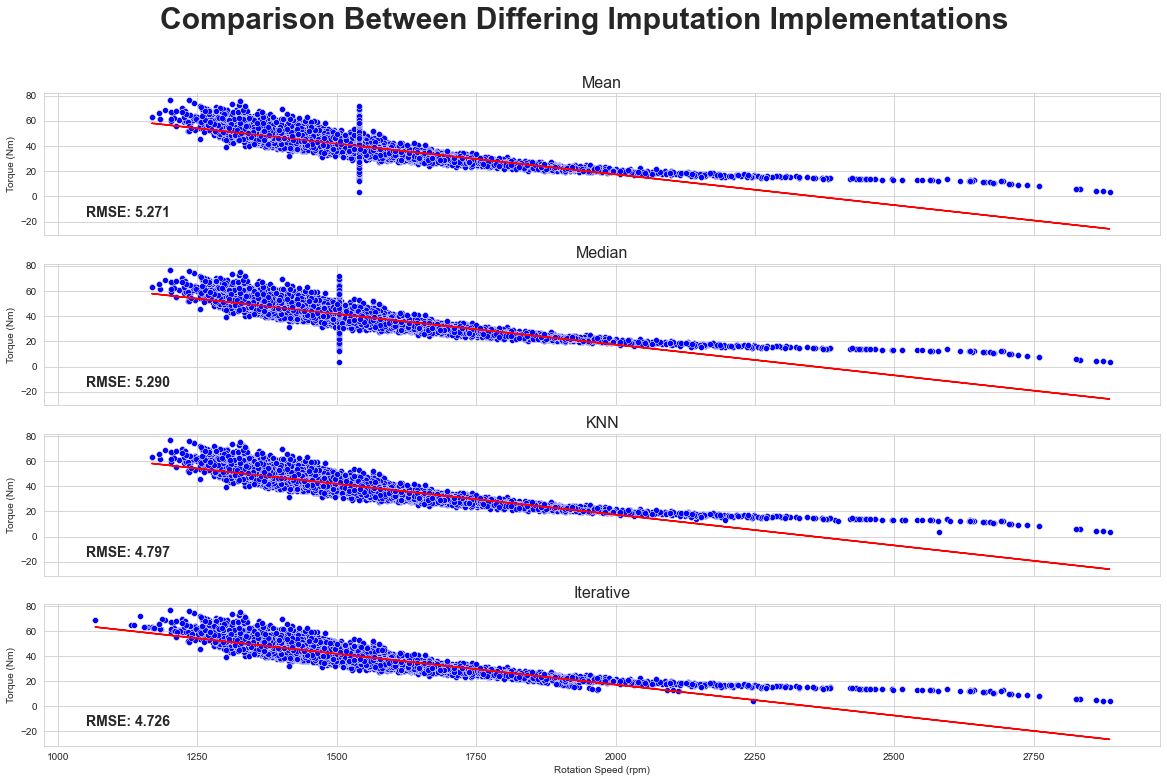

In [204]:
# imputer class
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.metrics import mean_squared_error

#impute categorical data using SimpleImputer
categorical_df = pd.DataFrame(SimpleImputer(strategy='most_frequent').fit_transform(categorical_df), columns = categorical_df.columns)

# Mean Imputation for Numerical Data
mean_imputer = SimpleImputer(strategy='mean')
mean_imputed = mean_imputer.fit_transform(numerical_df)
mean = pd.DataFrame(mean_imputed, columns=numerical_df.columns)

# Median Imputation for Numerical Data
median_imputer = SimpleImputer(strategy='median')
median_imputed = median_imputer.fit_transform(numerical_df)
median = pd.DataFrame(median_imputed, columns=numerical_df.columns)

# KNN Imputation for Numerical Data
knn_imputer = KNNImputer(n_neighbors=7,weights='uniform')
knn_imputed = knn_imputer.fit_transform(numerical_df)
knn = pd.DataFrame(knn_imputed, columns=numerical_df.columns)

# Iterative Imputation for Numerical Data
iter_imputer = IterativeImputer(random_state=42)
iter_imputed = iter_imputer.fit_transform(numerical_df)
iterated = pd.DataFrame(iter_imputed, columns=numerical_df.columns)

# Comparison between different imputations
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(20, 12))
fig.suptitle('Comparison Between Differing Imputation Implementations', fontsize=30,fontweight='bold')
axes = np.reshape(axes, -1)

data1 = [mean, median,knn, iterated]
titles = ['Mean', 'Median','KNN', 'Iterative']

for i, numerical_df in enumerate(data1):
    # Plotting the data
    x = numerical_df['Rotation Speed (rpm)']
    y = numerical_df['Torque (Nm)']
    sns.scatterplot(x, y, ax=axes[i], color='blue')

    # add linear regression line
    m, b = np.polyfit(x, y, 1)
    fit = m*x + b
    axes[i].plot(x, fit, color='red')

    # Setting the titles and including the Root Mean Square values
    axes[i].set_title(titles[i], fontsize=16)
    rmse = "{:.3f}".format(round(mean_squared_error(y, fit, squared=False), 3))
    axes[i].text(1050, -16 ,f'RMSE: {rmse}', fontsize=14, fontweight='bold')

#iterative imputation used as it has the lowest rsme value
numerical_df = iterated
display(np.shape(numerical_df))
display(np.shape(categorical_df))



## (A3) Choice of Impute Implementation Method:
> **Iterative Implementation** as it has the *lowest* RSME Value


<br>

# (B) Feature Engineering
> Creating new features to enhance accuracy of model and increase relevance of data.

In [205]:
# Stitch the dataframes together into one
cleaned_df = pd.merge(numerical_df, categorical_df, left_index=True, right_index=True)
cleaned_df = cleaned_df.reset_index()
cleaned_df = cleaned_df.drop(['index'],axis=1)

# Change name of product ID to LEFT(1) Product Code
cleaned_df['Product ID'] = cleaned_df['Product ID'].astype(str).str[0]
cleaned_df = cleaned_df.rename(columns={'Product ID':'Product Code'})

# Add the 3 features
cleaned_df['T Difference Squared (C^2)'] = (cleaned_df['Ambient T (C)']- cleaned_df['Process T (C)'])**2
cleaned_df['Tool Lifespan/Temp Increase^2 (min/C^2)'] = round(cleaned_df['Tool Lifespan (min)'] /cleaned_df['T Difference Squared (C^2)'])
cleaned_df['Horsepower (HP)'] = (cleaned_df['Rotation Speed (rpm)'] * cleaned_df['Torque (Nm)']) /5252
cleaned_df = cleaned_df.iloc[:, [7,6,1,0,8,4,9,2,3,10,5]]

display(cleaned_df)


,Product Code,Quality,Process T (C),Ambient T (C),T Difference Squared (C^2),Tool Lifespan (min),Tool Lifespan/Temp Increase^2 (min/C^2),Rotation Speed (rpm),Torque (Nm),Horsepower (HP),Machine Status
0,K,M,36.15,27.05,82.81,211.0,3.0,1351.391316,51.0,13.122802,0.0
1,S,M,36.35,27.15,84.64,208.0,2.0,1752.000000,27.8,9.273724,0.0
2,K,M,36.35,27.15,84.64,205.0,2.0,1456.000000,48.8,13.528713,0.0
3,K,L,36.25,27.05,84.64,203.0,2.0,1685.000000,27.1,8.694497,0.0
4,K,L,36.25,27.05,84.64,201.0,2.0,1654.000000,31.0,9.762757,0.0
...,...,...,...,...,...,...,...,...,...,...,...
19755,S,L,34.75,24.05,114.49,172.0,2.0,1326.000000,75.4,19.036634,1.0
19756,S,L,38.75,27.35,129.96,198.0,2.0,1272.000000,59.2,14.337852,1.0
19757,Z,L,36.55,24.55,144.00,222.0,2.0,1501.000000,49.8,14.232635,1.0
19758,S,L,38.65,27.25,129.96,198.0,2.0,1272.000000,59.2,14.337852,1.0




### (B1) Features
1. Product Code
    >*Product Code*

2. Quality
    >*Quality*


3. Ambient Temperature$\ (\degree C) $
    >*Ambient T*


4. Process Temperature$\ (\degree C) $
    >*Process T*


5. Temperature Difference Squared$\ (\degree C^2)$
    >*T Difference Squared (C^2)*


6. Tool Lifespan$\ (min)$
    >*Tool Lifespan*

7. Tool Lifespan per Temp Increase Squared$\ (min/ \degree C^2) $
    >*Tool Lifespan/Temp Increase^2*


8. Rotation Speed$\ (rpm) $
    >*Rotation Speed*


9. Torque$\ (Nm) $
    >*Torque*


10. Horsepower$\ (hp) $
    >*Horsepower*


11. Machine Status
    >*Machine Status*

<b>

# (C) Machine Learning Models

## (C1) K-Nearest Neighbours (KNN)
<br>

### (C1A) Modelling
<br>

[References](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [215]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics


#splitting the data into training and test sets (80:20)

X = np.transpose(np.array
    (
    [
        cleaned_df['T Difference Squared (C^2)'],
        cleaned_df['Torque (Nm)'],
        cleaned_df['Tool Lifespan (min)'],
        cleaned_df['Rotation Speed (rpm)'],
        cleaned_df['Tool Lifespan/Temp Increase^2 (min/C^2)'],
        cleaned_df['Horsepower (HP)']
    ]
    ))
y = np.transpose(np.array(cleaned_df['Machine Status']))
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.4,random_state=4)

#Try running from k-1 through 100 and record testing accuracy
k_range=range(1,100)
scores={}
scores_list = []
for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train,y_train)
        y_pred = knn.predict(X_test)
        scores[k] = metrics.accuracy_score(y_test,y_pred)
        scores_list.append (metrics.accuracy_score(y_test,y_pred))




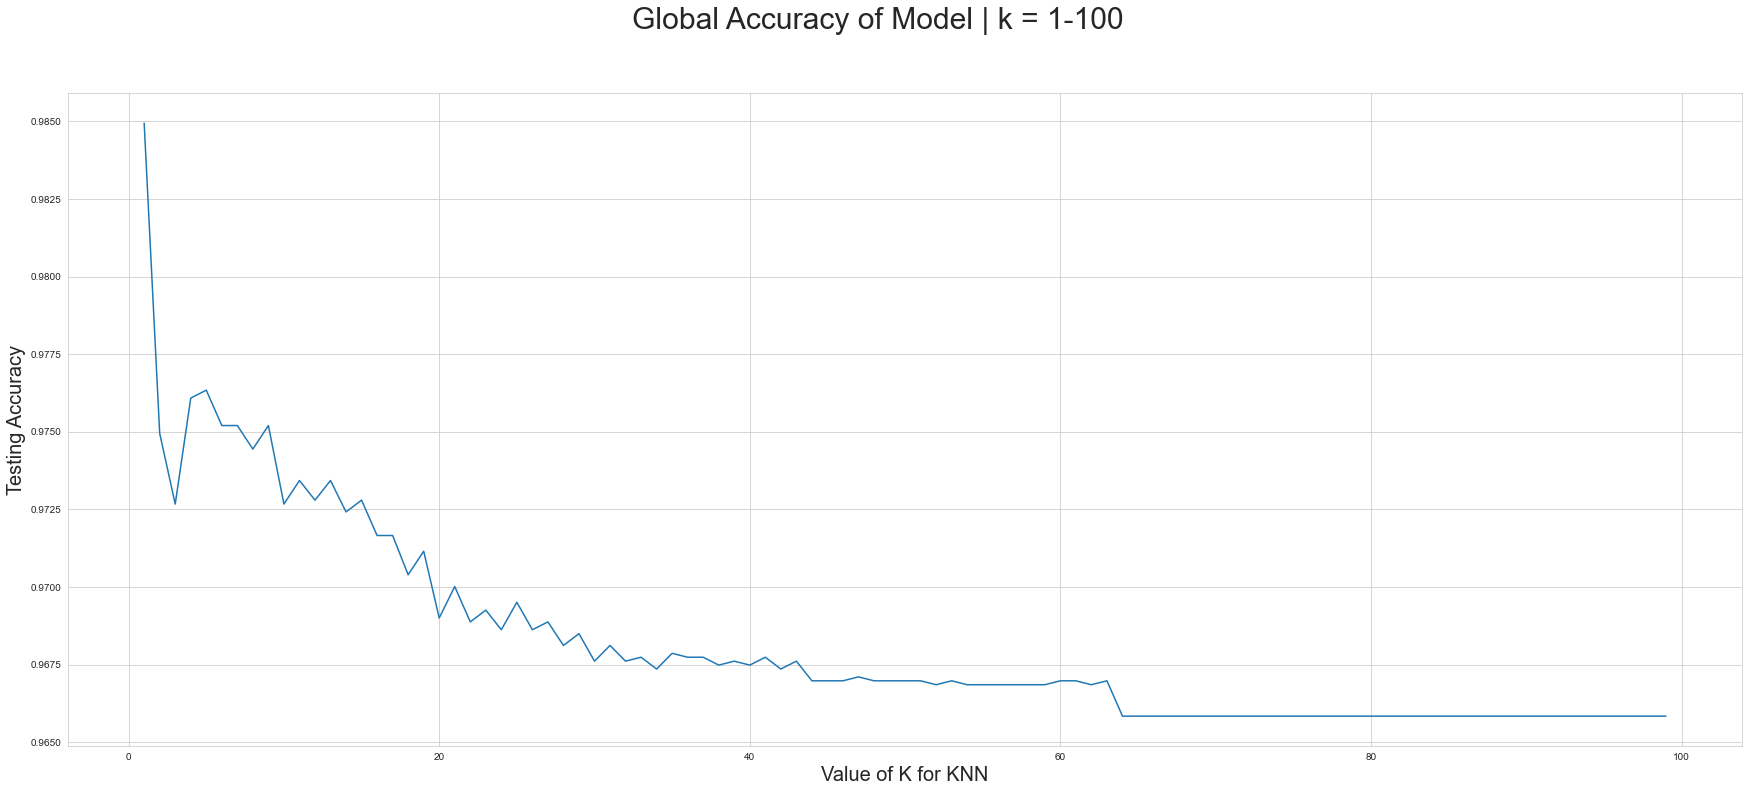

In [216]:
#plot the relationship between K and the testing accuracy
plt.plot(k_range, scores_list)
plt.suptitle('Global Accuracy of Model | k = 1-100',fontsize=30)
plt.xlabel('Value of K for KNN',fontsize=20)
plt.ylabel('Testing Accuracy',fontsize=20)
plt.rcParams["figure.figsize"] = (30,12)
plt.show()

#### (C1A.1) Observations
We can see that the accuracy of the model where `k=1` is the highest.

This is due to *overfitting* of data, where you estimate your probability based on a single sample: your closest neighbor
<br>

As k increases, we can see an *initial* incline, where the percentage increases from about 0.553 to 0.630 over about an increase of 35 for k.
<br>

However,

The smaller values for k , not only makes our classifier so sensitive to noise but also may lead to the overfitting problem.

Large values for k also may lead to underfitting.


34


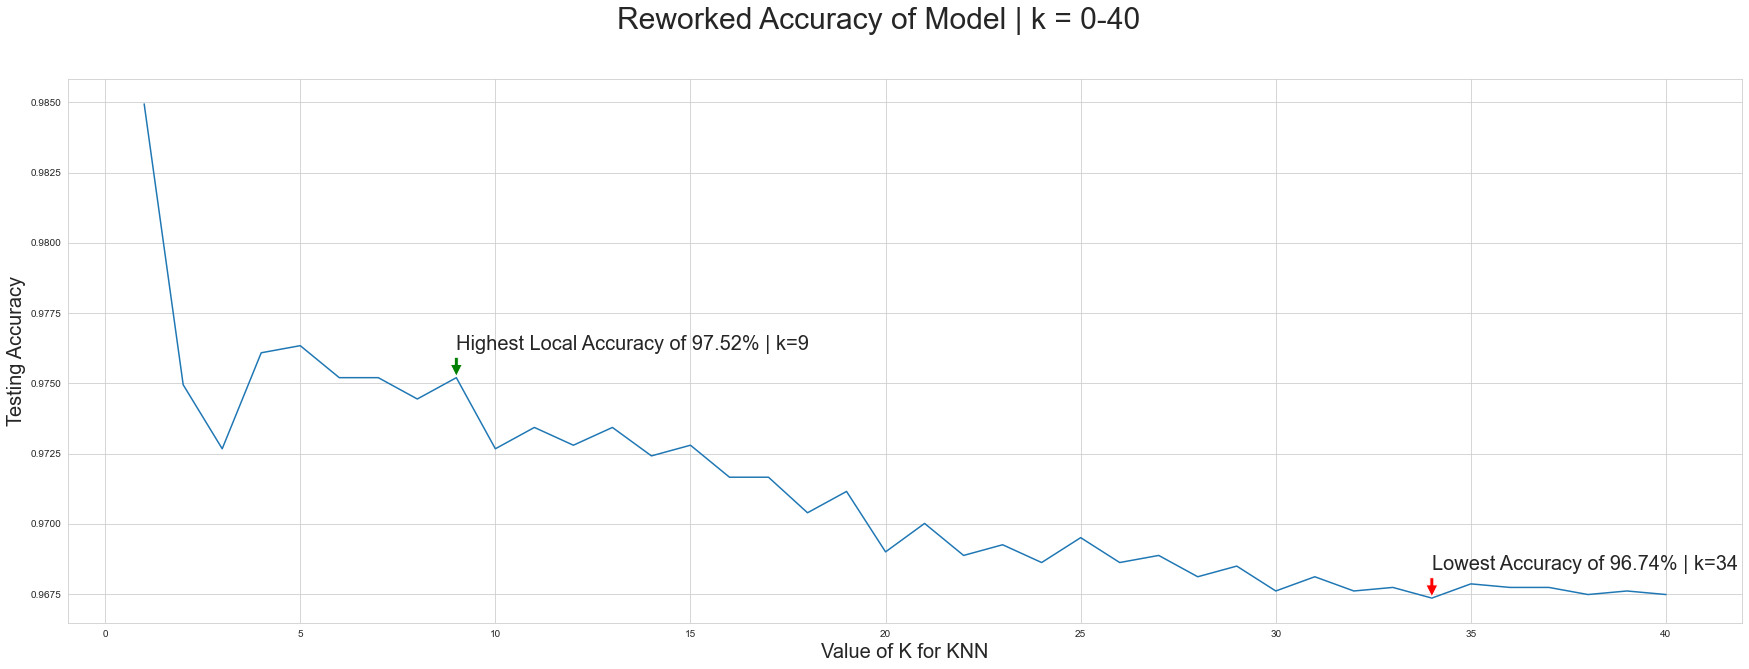

In [219]:
# Get rid of all k values before 30
x = list(scores.keys())[0:40]
y = list(scores.values())[0:40]

#plot new graph
fig = plt.figure()
ax = fig.add_subplot(111)


line, = ax.plot(x, y)

xmax = 9
ypos = x.index(xmax)
ymax = y[ypos]

ax.annotate(f'Highest Local Accuracy of {round(100*round(ymax,4),2)}% | k=9', xy=(xmax, ymax), xytext=(xmax, ymax+0.001),
            arrowprops=dict(facecolor='green', shrink=0.05),fontsize=20)

ymin = min(y)
xpos = y.index(ymin)
xmin = x[xpos]
print(xmin)

ax.annotate(f'Lowest Accuracy of {round(100*round(ymin,4),2)}% | k=34', xy=(xmin, ymin), xytext=(xmin, ymin+0.001),
            arrowprops=dict(facecolor='red', shrink=0.05),fontsize=20)

plt.suptitle('Reworked Accuracy of Model | k = 0-40',fontsize=30)
plt.xlabel('Value of K for KNN',fontsize=20)
plt.ylabel('Testing Accuracy',fontsize=20)
plt.rcParams["figure.figsize"] = (30,10)
plt.show()

However, we can see that the accuracy for the model *peaks* at an estimated `97.52%` where `k=9`.

After `k` passes `9`, we can see a *gradual decline* in accuracy once again.

<br>

#### (C1A.2) Explanations




### (C1B) Cross Validation
> Cross-validation, sometimes called rotation estimation or out-of-sample testing, is any of various similar model validation techniques for assessing how the results of a statistical analysis will generalize to an independent data set.
>
> Cross-validation is a resampling method that uses different portions of the data to test and train a model on different iterations.
>
> [Reference 1](https://en.wikipedia.org/wiki/Cross-validation_(statistics))
> [Reference 2](https://scikit-learn.org/stable/modules/cross_validation.html)

In [221]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.model_selection import KFold
#initialise values for processing
X = np.transpose(np.array
    (
    [
        cleaned_df['T Difference Squared (C^2)'],
        cleaned_df['Torque (Nm)'],
        cleaned_df['Tool Lifespan (min)'],
        cleaned_df['Rotation Speed (rpm)'],
        cleaned_df['Tool Lifespan/Temp Increase^2 (min/C^2)'],
        cleaned_df['Horsepower (HP)']
    ]
    ))
y = np.transpose(np.array(cleaned_df['Machine Status']))
print(cleaned_df['Machine Status'].value_counts())
#make pipeline for ease of access to data and models
# TODO: explore preprocessing.StandardScaler()

clf = make_pipeline(preprocessing.StandardScaler(), KNeighborsClassifier(n_neighbors=41))



cv_range = np.arange(2,20)
cv_scores = []


# Calculate accuracy for range of cv values
for i in cv_range:
    # prepare the cross-validation procedure
    cv = KFold(n_splits=i, random_state=20, shuffle=True)
    scores = cross_val_score(clf, X, y, cv=cv,scoring='accuracy')
    cv_scores.append(scores.mean())




0.0    19088
1.0      672
Name: Machine Status, dtype: int64


97.40 accuracy with a standard deviation of 0.00


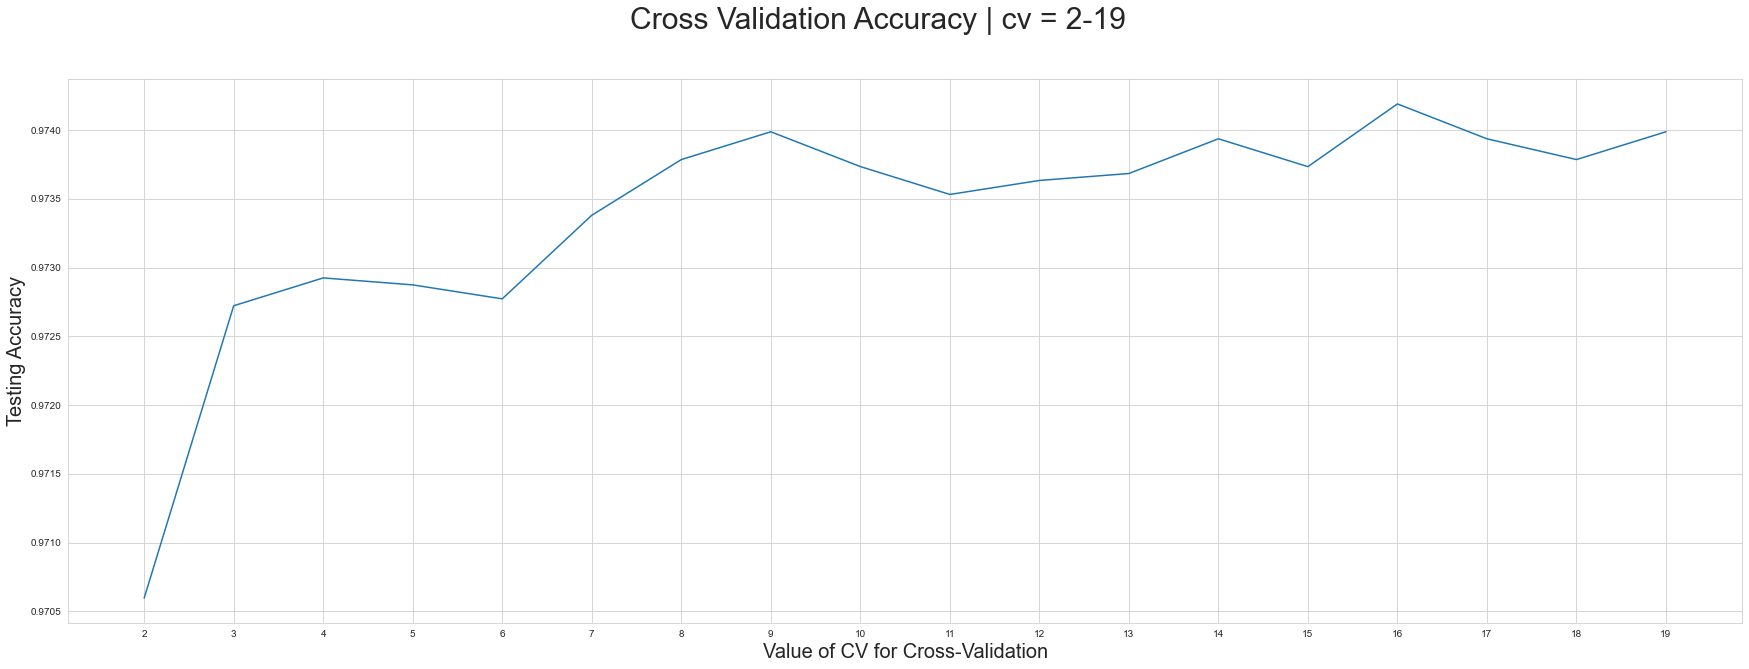

In [222]:
#plot new graph
fig = plt.figure()
ax = fig.add_subplot(111)

line, = ax.plot(cv_range, cv_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (100*(scores.mean()), scores.std()))

plt.suptitle('Cross Validation Accuracy | cv = 2-19',fontsize=30)
plt.xlabel('Value of CV for Cross-Validation',fontsize=20)
plt.ylabel('Testing Accuracy',fontsize=20)
plt.rcParams["figure.figsize"] = (30,12)
plt.xticks(cv_range)
plt.show()

#### (C1B.1) Observations
We can see that the accuracy of the model where `cv=2` is the highest, and this value continues to decrease as `cv` increases.

This is suggests that the lesser the number of folds of data, the greater the accuracy.
<br>

However, we decide on `cv=13` for the number of folds for cross validation for our KNN Classifier, as the reliability of the model is
<br>

Additionally,

For our accuracy parameter, ......

[References](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

#### (C1B.2) Explanations

### (C1C) KNN Weights

#### (C1C.1) Observations

#### (C1C.2) Explanations

### (C1D) KNN Algorithm

#### (C1D.1) Observations


#### (C1D.2) Explanations

### (C1D) Distance Metric

#### (C1D.1) Observations

#### (C1D.2) Explanations

<br>

## (C2) Support Vector Machine (SVM)

In [211]:
from sklearn import svm

clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9702682186234818

## (C3) Logistic Regression

## (XX) Stacking?